In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

In [2]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


# Data preprocessing 

In [3]:

MISSING_TOKEN = 'None'

In [4]:

def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [5]:
data_location =  '../baseline-gen-data/medium/'
caption_file = data_location + 'captions-psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'


creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [6]:

with open(caption_file, 'r') as f:
    for line in f:
        # skip title
        if 'image,caption,psum,psum_sq' in line:
            continue

        image_name, text_label,psum,psum_sq = line.split(',')
        text_label = text_label.strip()

        struc_label = Caption(text_label, support_plural=True).get_structured()
        first_object = struc_label['objects'][0]
        mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
        write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{psum},{psum_sq}")
                

In [10]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,image_1.png,lion,None,A,347488.750000,323990.218750
1,image_2.png,lion,rampant,A,284055.562500,238163.890625
2,image_3.png,lion,rampant,A,347488.750000,323990.218750
3,image_4.png,lion,passt,A,289033.093750,245082.781250
4,image_5.png,lion,passt,A,349610.687500,326908.031250
...,...,...,...,...,...,...
714,image_715.png,eagle,doubleheaded,G,163572.843750,90899.632812
715,image_716.png,eagle,None,V,174215.671875,100297.773438
716,image_717.png,eagle,None,V,162246.562500,88134.375000
717,image_718.png,eagle,doubleheaded,V,173202.750000,99569.679688


In [11]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod           color
cross   None          A        12
                      B        12
lion    None          G        12
                      O        12
                      S        12
                      V        12
        passt         A        12
                      B        12
                      G        12
                      O        12
                      S        12
                      V        12
        passt guard   A        12
                      B        12
                      G        12
                      O        12
                      S        12
                      V        12
        rampant       A        12
                      B        12
                      G        12
                      O        12
                      S        12
                      V        12
lion's  head          A        12
                      B        12
                      G        12
                      O        12
                    

In [12]:
classes = list(column_values.to_dict().keys())
classes

[('cross', 'None', 'A'),
 ('cross', 'None', 'B'),
 ('lion', 'None', 'G'),
 ('lion', 'None', 'O'),
 ('lion', 'None', 'S'),
 ('lion', 'None', 'V'),
 ('lion', 'passt', 'A'),
 ('lion', 'passt', 'B'),
 ('lion', 'passt', 'G'),
 ('lion', 'passt', 'O'),
 ('lion', 'passt', 'S'),
 ('lion', 'passt', 'V'),
 ('lion', 'passt guard', 'A'),
 ('lion', 'passt guard', 'B'),
 ('lion', 'passt guard', 'G'),
 ('lion', 'passt guard', 'O'),
 ('lion', 'passt guard', 'S'),
 ('lion', 'passt guard', 'V'),
 ('lion', 'rampant', 'A'),
 ('lion', 'rampant', 'B'),
 ('lion', 'rampant', 'G'),
 ('lion', 'rampant', 'O'),
 ('lion', 'rampant', 'S'),
 ('lion', 'rampant', 'V'),
 ("lion's", 'head', 'A'),
 ("lion's", 'head', 'B'),
 ("lion's", 'head', 'G'),
 ("lion's", 'head', 'O'),
 ("lion's", 'head', 'S'),
 ('lion', 'None', 'B'),
 ("lion's", 'head', 'V'),
 ('eagle', 'doubleheaded', 'V'),
 ('cross', 'patonce', 'G'),
 ('cross', 'None', 'G'),
 ('cross', 'None', 'O'),
 ('cross', 'None', 'S'),
 ('cross', 'None', 'V'),
 ('cross', 'mol

In [13]:
len(classes)

60

In [14]:
type(classes[0])

tuple

In [15]:
np.nan

nan

In [16]:
# Give unique number to each class
CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('cross', 'None', 'A'),
 1: ('cross', 'None', 'B'),
 2: ('lion', 'None', 'G'),
 3: ('lion', 'None', 'O'),
 4: ('lion', 'None', 'S'),
 5: ('lion', 'None', 'V'),
 6: ('lion', 'passt', 'A'),
 7: ('lion', 'passt', 'B'),
 8: ('lion', 'passt', 'G'),
 9: ('lion', 'passt', 'O'),
 10: ('lion', 'passt', 'S'),
 11: ('lion', 'passt', 'V'),
 12: ('lion', 'passt guard', 'A'),
 13: ('lion', 'passt guard', 'B'),
 14: ('lion', 'passt guard', 'G'),
 15: ('lion', 'passt guard', 'O'),
 16: ('lion', 'passt guard', 'S'),
 17: ('lion', 'passt guard', 'V'),
 18: ('lion', 'rampant', 'A'),
 19: ('lion', 'rampant', 'B'),
 20: ('lion', 'rampant', 'G'),
 21: ('lion', 'rampant', 'O'),
 22: ('lion', 'rampant', 'S'),
 23: ('lion', 'rampant', 'V'),
 24: ("lion's", 'head', 'A'),
 25: ("lion's", 'head', 'B'),
 26: ("lion's", 'head', 'G'),
 27: ("lion's", 'head', 'O'),
 28: ("lion's", 'head', 'S'),
 29: ('lion', 'None', 'B'),
 30: ("lion's", 'head', 'V'),
 31: ('eagle', 'doubleheaded', 'V'),
 32: ('cross', 'patonce',

In [17]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [18]:
import math
def get_image_class(item):
    for k,v in CLASSES_MAP.items():
        if v == item:
            return k
    return None
    
c1 = get_image_class(('lion', 'rampant','B'))   
c2 = get_image_class(('lion', MISSING_TOKEN, 'B'))   
c1,c2


(19, 29)

In [19]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq.txt'
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [20]:
for _,line in df.iterrows():
    image_name,charge,mod,color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['psum'],line['psum_sq']
    image_class = get_image_class((charge, mod, color))

    write_line_to_file(new_with_class_caption_file, f"{image_name},{charge},{mod},{color},{psum},{psum_sq},{image_class}")
                

In [21]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,image_1.png,lion,None,A,347488.750000,323990.218750,59
1,image_2.png,lion,rampant,A,284055.562500,238163.890625,18
2,image_3.png,lion,rampant,A,347488.750000,323990.218750,18
3,image_4.png,lion,passt,A,289033.093750,245082.781250,6
4,image_5.png,lion,passt,A,349610.687500,326908.031250,6
...,...,...,...,...,...,...,...
714,image_715.png,eagle,doubleheaded,G,163572.843750,90899.632812,57
715,image_716.png,eagle,None,V,174215.671875,100297.773438,54
716,image_717.png,eagle,None,V,162246.562500,88134.375000,54
717,image_718.png,eagle,doubleheaded,V,173202.750000,99569.679688,31


In [23]:
train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 431 train images
There are 143 val images
There are 145 test images


,image,charge,mod,color,psum,psum_sq,class
0,image_589.png,eagle,None,S,262836.656250,226468.312500,53
1,image_371.png,cross,patonce,B,321990.812500,289140.093750,44
2,image_571.png,cross,None,V,171203.921875,95383.546875,36
3,image_561.png,cross,moline,S,159520.343750,84709.187500,41
4,image_180.png,lion,None,A,199353.593750,138443.000000,59
...,...,...,...,...,...,...,...
138,image_35.png,lion,passt,S,302701.750000,273126.781250,10
139,image_357.png,lion,passt guard,V,166389.390625,91636.750000,17
140,image_716.png,eagle,None,V,174215.671875,100297.773438,54
141,image_263.png,lion,rampant,O,199140.937500,132483.015625,21


# Dataset and Dataloader  

In [24]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [117]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")

        # # resize the image t0 100x100 to improve the iteration time
        # crops_size = 100,100
        # img.thumbnail(crops_size, Image.ANTIALIAS)

        # apply the transfromation to the image
        if self.transform is not None:
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)

        return img_t

    def _get_label_class(self, idx):

        label_class = self.classes[idx]
        
        return label_class

    



In [118]:
BATCH_SIZE = 5
# NUM_WORKER = 2 #### this needs multi-core
NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [119]:
images_location = data_location + '/res_images'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [120]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(5, 0)), tensor([], size=(5, 0)))

In [121]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [122]:
std = get_std(train_dataset, train_data_loader, mean)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


# Dataset and Dataloader  

In [123]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [124]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=../baseline-gen-data/medium//res_images, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.26988284945378965, std=0.3331156618742065)
 ), device=cpu, df=             image charge           mod color           psum        psum_sq  \
 0    image_160.png   lion          None     G  215846.218750  149419.843750   
 1    image_630.png  eagle  doubleheaded     B  207822.640625  138481.406250   
 2    image_444.png  cross          None     O  252698.640625  191513.640625   
 3     image_91.png   lion          None     S  168479.968750   95870.273438   
 4    image_422.png  cross        moline     G  197271.968750  122768.687500   
 ..             ...    ...           ...   ...            ...            ...   
 426  image_583.png  eagle  doubleheaded     B  288152.593750  247810.406250   
 427   image_14.png   lion         passt  

In [125]:
# Data Loader  -  using Sampler (YT Video

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

In [126]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-

In [127]:

dataiter = iter(val_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-

In [128]:

dataiter = iter(test_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


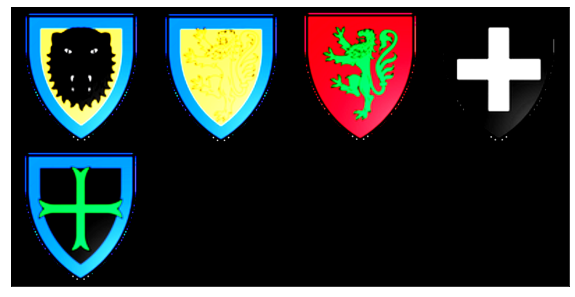

In [129]:
# Visualize one training batch
for images,classes,_,_,_ in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


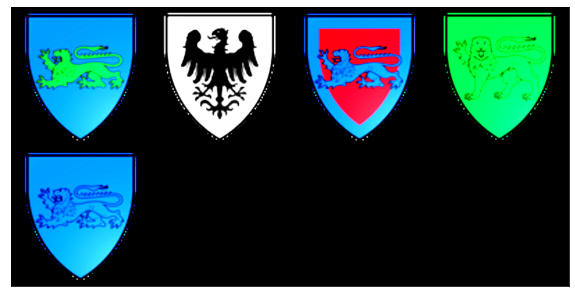

In [130]:
# Visualize one validation batch
for images,classes,_,_,_ in val_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

# Model Definition

In [131]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


In [132]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


# Model Training, Validation and Testing

In [133]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 20


In [134]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [135]:
### Training Code
from tqdm import tqdm

for epoch in range(epochs):
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    with tqdm(train_data_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels,_,_,_ in tepoch: 
            images = images.to(device)
            labels = labels.to(device)

            #Reset Grads
            optimizer.zero_grad()

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss & Backward, Update Weights (Step)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            #Append loss & acc
            loss_value = loss.item()
            train_epoch_loss.append(loss_value)
            train_epoch_accuracy.append(acc)
            
            tepoch.set_postfix({'train_epoch_loss': loss_value})
#             tepoch.set_postfix({'train_epoch_accuracy',acc})

            if _iter % 500 == 0:
                print("> Iteration {} < ".format(_iter))
                print("Iter Loss = {}".format(round(loss_value, 4)))
                print("Iter Accuracy = {} % \n".format(acc))

#             _iter += 1

    #Validation
    with tqdm(val_data_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels,_,_,_ in tepoch:
            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
            val_epoch_accuracy.append(acc)
            tepoch.set_postfix({'val_epoch_loss': loss_value})
#             tepoch.set_postfix({'val_epoch_accuracy',acc})

    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    


Epoch 0:   0%|                                        | 0/29 [00:00<?, ?batch/s]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:   3%|▍          | 1/29 [00:03<01:51,  3.99s/batch, val_epoch_loss=3.55]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:   7%|▊          | 2/29 [00:08<01:48,  4.01s/batch, val_epoch_loss=3.51]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  10%|█▏         | 3/29 [00:12<01:43,  4.00s/batch, val_epoch_loss=3.56]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  14%|█▌         | 4/29 [00:15<01:39,  3.99s/batch, val_epoch_loss=2.77]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  17%|█▉         | 5/29 [00:19<01:35,  3.98s/batch, val_epoch_loss=3.45]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  21%|██▎        | 6/29 [00:23<01:31,  3.98s/batch, val_epoch_loss=3.17]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  24%|██▋        | 7/29 [00:27<01:27,  3.98s/batch, val_epoch_loss=2.66]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  28%|███        | 8/29 [00:31<01:23,  3.98s/batch, val_epoch_loss=3.38]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  31%|███▍       | 9/29 [00:35<01:19,  3.97s/batch, val_epoch_loss=3.33]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  34%|███▍      | 10/29 [00:39<01:15,  3.97s/batch, val_epoch_loss=3.22]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  38%|███▊      | 11/29 [00:43<01:11,  3.97s/batch, val_epoch_loss=3.69]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  41%|████▏     | 12/29 [00:47<01:07,  3.97s/batch, val_epoch_loss=3.66]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  45%|████▍     | 13/29 [00:51<01:03,  3.97s/batch, val_epoch_loss=3.68]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  48%|████▊     | 14/29 [00:55<00:59,  3.97s/batch, val_epoch_loss=3.18]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  52%|█████▏    | 15/29 [00:59<00:55,  3.98s/batch, val_epoch_loss=3.57]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  55%|█████▌    | 16/29 [01:03<00:51,  3.98s/batch, val_epoch_loss=3.73]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  59%|██████▍    | 17/29 [01:07<00:47,  3.98s/batch, val_epoch_loss=3.5]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  62%|██████▏   | 18/29 [01:11<00:43,  3.98s/batch, val_epoch_loss=3.06]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  66%|██████▌   | 19/29 [01:15<00:39,  3.97s/batch, val_epoch_loss=3.53]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  69%|██████▉   | 20/29 [01:19<00:35,  3.98s/batch, val_epoch_loss=3.37]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  72%|███████▏  | 21/29 [01:23<00:31,  3.97s/batch, val_epoch_loss=3.74]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  76%|███████▌  | 22/29 [01:27<00:27,  3.98s/batch, val_epoch_loss=2.99]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  79%|███████▉  | 23/29 [01:31<00:23,  3.98s/batch, val_epoch_loss=4.09]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  83%|████████▎ | 24/29 [01:35<00:19,  3.98s/batch, val_epoch_loss=2.85]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  86%|████████▌ | 25/29 [01:39<00:15,  3.98s/batch, val_epoch_loss=2.89]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  90%|████████▉ | 26/29 [01:43<00:11,  3.97s/batch, val_epoch_loss=3.61]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  93%|█████████▎| 27/29 [01:47<00:07,  3.98s/batch, val_epoch_loss=3.85]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0:  97%|█████████▋| 28/29 [01:51<00:03,  3.97s/batch, val_epoch_loss=3.32]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 0: 100%|██████████| 29/29 [01:53<00:00,  3.92s/batch, val_epoch_loss=3.38]


** Epoch 0 ** - Epoch Time 1261
Train Loss = 4.4787
Train Accuracy = 4.367816091954023 % 

Val Loss = 3.3888
Val Accuracy = 13.563217241379311 % 



Epoch 1:   0%|                                        | 0/29 [00:00<?, ?batch/s]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:   3%|▍          | 1/29 [00:03<01:50,  3.96s/batch, val_epoch_loss=2.85]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:   7%|▊          | 2/29 [00:07<01:47,  3.99s/batch, val_epoch_loss=2.41]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  10%|█▏         | 3/29 [00:11<01:43,  3.98s/batch, val_epoch_loss=3.64]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  14%|█▌         | 4/29 [00:16<01:40,  4.04s/batch, val_epoch_loss=3.09]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  17%|█▉         | 5/29 [00:20<01:38,  4.09s/batch, val_epoch_loss=1.96]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  21%|██▎        | 6/29 [00:24<01:33,  4.07s/batch, val_epoch_loss=2.27]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  24%|██▋        | 7/29 [00:28<01:28,  4.03s/batch, val_epoch_loss=1.53]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  28%|███        | 8/29 [00:32<01:24,  4.02s/batch, val_epoch_loss=2.74]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  31%|███▍       | 9/29 [00:36<01:20,  4.00s/batch, val_epoch_loss=1.92]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  34%|███▍      | 10/29 [00:40<01:16,  4.00s/batch, val_epoch_loss=2.43]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  38%|████▏      | 11/29 [00:44<01:12,  4.01s/batch, val_epoch_loss=3.4]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  41%|████▏     | 12/29 [00:48<01:08,  4.00s/batch, val_epoch_loss=3.42]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  45%|████▍     | 13/29 [00:52<01:04,  4.00s/batch, val_epoch_loss=2.41]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  48%|████▊     | 14/29 [00:56<00:59,  4.00s/batch, val_epoch_loss=2.22]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  52%|█████▏    | 15/29 [01:00<00:55,  4.00s/batch, val_epoch_loss=2.94]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  55%|█████▌    | 16/29 [01:04<00:51,  4.00s/batch, val_epoch_loss=2.65]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  59%|█████▊    | 17/29 [01:08<00:48,  4.01s/batch, val_epoch_loss=2.62]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  62%|██████▏   | 18/29 [01:12<00:44,  4.01s/batch, val_epoch_loss=3.29]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  66%|██████▌   | 19/29 [01:16<00:40,  4.01s/batch, val_epoch_loss=1.97]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  69%|██████▉   | 20/29 [01:20<00:36,  4.01s/batch, val_epoch_loss=2.69]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  72%|███████▏  | 21/29 [01:24<00:32,  4.01s/batch, val_epoch_loss=3.45]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  76%|███████▌  | 22/29 [01:28<00:28,  4.01s/batch, val_epoch_loss=3.27]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  79%|████████▋  | 23/29 [01:32<00:24,  4.01s/batch, val_epoch_loss=3.8]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  83%|████████▎ | 24/29 [01:36<00:20,  4.01s/batch, val_epoch_loss=2.46]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  86%|████████▌ | 25/29 [01:40<00:16,  4.01s/batch, val_epoch_loss=2.31]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  90%|████████▉ | 26/29 [01:44<00:12,  4.02s/batch, val_epoch_loss=2.72]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  93%|█████████▎| 27/29 [01:48<00:08,  4.01s/batch, val_epoch_loss=2.77]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1:  97%|█████████▋| 28/29 [01:52<00:04,  4.01s/batch, val_epoch_loss=2.93]

tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          ...,
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
          [-0.8102, -0.8102, -

Epoch 1: 100%|██████████| 29/29 [01:54<00:00,  3.96s/batch, val_epoch_loss=1.99]


** Epoch 1 ** - Epoch Time 1277
Train Loss = 2.9585
Train Accuracy = 19.770114942528735 % 

Val Loss = 2.6948
Val Accuracy = 21.60919655172414 % 



Epoch 2:  62%|████▉   | 54/87 [12:13<07:28, 13.59s/batch, train_epoch_loss=1.98]


KeyboardInterrupt: 